In [48]:
import json, sys, time
import pandas as pd 
import pickle 
import sqlalchemy as sq

# ML tasks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron

In [49]:
from load import stream_bulks, data_full, BULK_SIZE
from pm_processing import describe_model

In [76]:
import time
import sqlite3

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,  create_engine, LargeBinary
from sqlalchemy.orm import scoped_session, sessionmaker

Base = declarative_base()
DBSession = scoped_session(sessionmaker())
engine = None


class PM(Base):
    __tablename__ = "pm"
    id = Column(Integer, primary_key=True)
    model = Column(LargeBinary)


def init_sqlalchemy(dbname='sqlite:///sqlalchemy.db'):
    global engine
    engine = create_engine(dbname, echo=False)
    DBSession.remove()
    DBSession.configure(bind=engine, autoflush=False, expire_on_commit=False)
    Base.metadata.drop_all(engine)
    Base.metadata.create_all(engine)


def insert_sqlalchemy_orm(model):
    init_sqlalchemy()
    pm = PM()
    pm.model = model
    DBSession.add(pm)
    DBSession.commit()

def get_last():
    return DBSession.query(PM).order_by(PM.id.desc()).first()

In [77]:
init_sqlalchemy()
assert get_last() == None

In [ ]:
values = []
for i, json_dicts in enumerate(stream_bulks(data_full, BULK_SIZE)):
    if i % 100 ==0 : 
        print(i)
    if i > 500:
        break
    if i == 0:
        model = SGDClassifier()
    else: 
        previous_pickle = get_last().model
        model = pickle.loads(previous_pickle)
    df = pd.DataFrame(json.loads(json_dicts))
    dataset = df[['competence','network_ability','promoted']] # skip id
    X_vals = dataset.iloc[:, :-1].values
    y_vals = dataset.iloc[:, -1].values

    # if not first model, test with the same data
    if i != 0:
        test_start = time.time()
        values[-1]['accuracy'] = model.score(X_vals, y_vals)
        values[-1]['test_time'] = time.time() - test_start
        values[-1]['test_pos'] = int(sum(y_vals))

    # train model 
    values.append({})
    
    train_start = time.time()
    model.partial_fit(X_vals, y_vals, classes=[0,1])
    values[-1]['train_time'] = time.time() - train_start
    values[-1]['train_pos'] = int(sum(y_vals))

    # extract parameters
    model_description = describe_model(
        'model',model,dataset.iloc[:, :-1],None
    )
    values[-1] = {**values[-1],**model_description}
    # store model
    previous_pickle = pickle.dumps(model)
    insert_sqlalchemy_orm(previous_pickle)
    #print(get_last().model)

0
100


In [57]:
df_validation = pd.DataFrame(values)

<AxesSubplot:xlabel='index'>

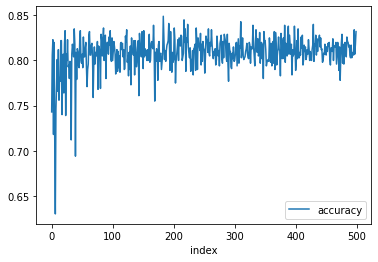

In [58]:
df_validation.reset_index().plot(x='index', y='accuracy')

In [ ]:
test_sqlalchemy_orm(100000)
test_sqlalchemy_orm_pk_given(100000)
test_sqlalchemy_orm_bulk_insert(100000)
test_sqlalchemy_core(100000)
test_sqlite3(100000)